In [34]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from google.colab import drive
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [35]:
!pip install basemap
!pip install basemap-data-hires
from mpl_toolkits.basemap import Basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Preliminary Analysis of Features

Loading the data

In [36]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out= pd.read_csv(loc,**kwargs)
    return out

import urllib
def getLargeFile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        url = gdrive
        urllib.request.urlretrieve(gdrive, loc)
        out= pd.read_csv(loc,**kwargs)
    return out

fname = ("Crime_Data_from_2020_to_Present.csv", 
         "https://drive.google.com/u/0/uc?id=1WwLkX_BADtPY83rFQ4CQ5Lbf6UcI055A&export=download&confirm=t&uuid=4e0aae58-2f5b-4420-941f-8f2f49ae0cb8&at=ALAFpqzX_FrSz-hUtqhaXe2ui7h6:1667673013562")
df = getLargeFile(fname)
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,04/14/2020 12:00:00 AM,02/13/2020 12:00:00 AM,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,AA,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468


In [37]:
df.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

In [38]:
for column in df.columns.values:
    print(f'{column} with {df[column].unique().shape[0]} unique values')

DR_NO with 590832 unique values
Date Rptd with 1028 unique values
DATE OCC with 1028 unique values
TIME OCC with 1439 unique values
AREA with 21 unique values
AREA NAME with 21 unique values
Rpt Dist No with 1189 unique values
Part 1-2 with 2 unique values
Crm Cd with 137 unique values
Crm Cd Desc with 137 unique values
Mocodes with 208301 unique values
Vict Age with 101 unique values
Vict Sex with 5 unique values
Vict Descent with 20 unique values
Premis Cd with 310 unique values
Premis Desc with 307 unique values
Weapon Used Cd with 79 unique values
Weapon Desc with 79 unique values
Status with 5 unique values
Status Desc with 5 unique values
Crm Cd 1 with 140 unique values
Crm Cd 2 with 121 unique values
Crm Cd 3 with 36 unique values
Crm Cd 4 with 7 unique values
LOCATION with 59096 unique values
Cross Street with 8687 unique values
LAT with 5352 unique values
LON with 4949 unique values


## Consolidating and Examining the Dates of Crimes

We first convert the dates to datetime objects, shown below

In [39]:
df['Date Rptd'] = df['Date Rptd'].apply(lambda x: dt.datetime.strptime(x, "%m/%d/%Y %H:%M:%S %p").date())
df['DATE OCC'] = df['DATE OCC'].apply(lambda x: dt.datetime.strptime(x, "%m/%d/%Y %H:%M:%S %p").date())
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])

We can take a look at which days of the week most crimes occurred

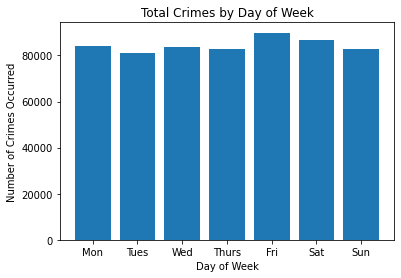

In [40]:
plt.bar(df['DATE OCC'].dt.day_of_week.value_counts().sort_index().index, df['DATE OCC'].dt.day_of_week.value_counts().sort_index())
plt.xticks(ticks = df['DATE OCC'].dt.day_of_week.value_counts().sort_index().index, labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Number of Crimes Occurred')
plt.title('Total Crimes by Day of Week')
plt.show()
plt.close()

Shown above, most crimes take place during the start of the weekend

We can also take a look at which months most crimes occurred

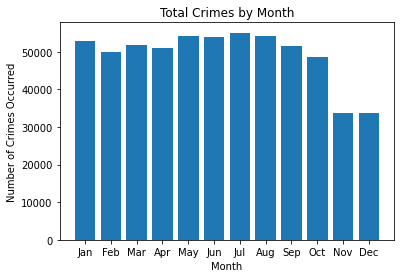

In [41]:
plt.bar(df['DATE OCC'].dt.month.value_counts().sort_index().index, df['DATE OCC'].dt.month.value_counts().sort_index())
plt.xticks(ticks = df['DATE OCC'].dt.month.value_counts().sort_index().index, \
    labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Total Crimes by Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes Occurred')
plt.show()
plt.close()

Evidently, crime occurs more over the summer and the start of the year

## Examining Crime Categories

We can look at the top 10 crime categories

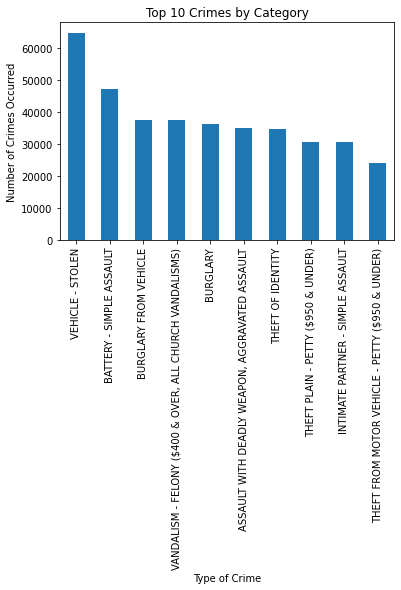

In [42]:
df['Crm Cd Desc'].value_counts()[:10].plot(kind = 'bar')
plt.xlabel('Type of Crime')
plt.ylabel('Number of Crimes Occurred')
plt.title('Top 10 Crimes by Category')
plt.show()
plt.close()

## Crime Evolution Over Time

Since the ultimate task of this project involves a Recurrent Neural Network with a time component, it is in our interest to obtain a preliminary idea of how crime evolves over time

### Total Crimes Over Time

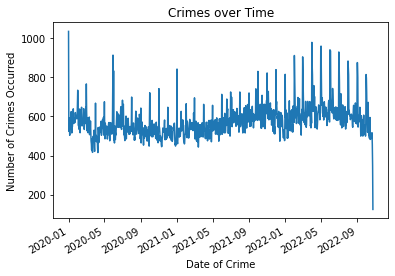

In [43]:
plt.plot(df['DATE OCC'].value_counts().sort_index().index, df['DATE OCC'].value_counts().sort_index())
plt.xlabel('Date of Crime')
plt.ylabel('Number of Crimes Occurred')
plt.title('Crimes over Time')
plt.gcf().autofmt_xdate()
plt.show()
plt.close()

### Crimes Occurred over Years, Grouped by Month

We must first format the data such that it can be used

In [44]:
df['Month OCC'] = df['DATE OCC'].dt.month
df['Year OCC'] = df['DATE OCC'].dt.year
month_year_occ = [str(m)+"/"+str(y) for m,y in zip(df["Month OCC"], df["Year OCC"])]
month_year_occ_formatted = [dt.datetime.strptime(d, "%m/%Y") for d in month_year_occ]
df["Month Year OCC"] = np.array(month_year_occ_formatted)

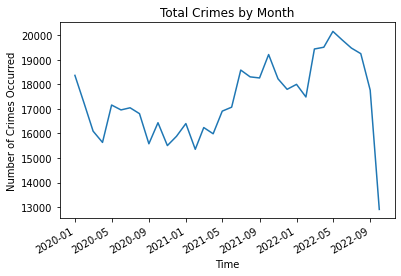

In [45]:
plt.plot(df["Month Year OCC"].value_counts().sort_index().index, df["Month Year OCC"].value_counts().sort_index())
plt.gcf().autofmt_xdate()
plt.title('Total Crimes by Month')
plt.xlabel('Time')
plt.ylabel('Number of Crimes Occurred')
plt.show()
plt.close()

### Crimes by Time of Day

We first define a few functions to read the military time format

In [46]:
# convert into 4-char strings
def makemil(time):
    ntime = ""
    if len(str(time)) == 1:
        ntime = "000" + str(time)
    if len(str(time)) == 2:
        ntime = "00" + str(time)
    if len(str(time)) == 3:
        ntime = "0" + str(time)
    if len(str(time)) == 4:
        ntime = str(time)
    return ntime

# function for retrieving the hour of the time
def returnhour(miltime):
    return miltime[:2]

In [47]:
df["TIME OCC"] = df["TIME OCC"].apply(makemil)

Plotting the number of crimes by time of day

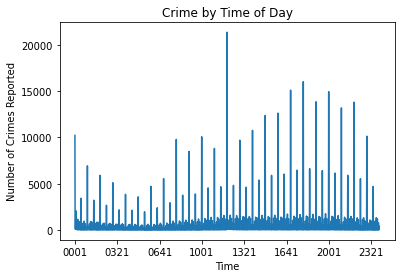

In [48]:
df['TIME OCC'].value_counts().apply(int).sort_index().plot()
plt.xlabel('Time')
plt.ylabel('Number of Crimes Reported')
plt.title('Crime by Time of Day')
plt.show()
plt.close()

We see that most crimes occur around midnight, which will be a key observation for our RNN

### Crimes by the Hour

In [49]:
df['Hour OCC'] =  df["TIME OCC"].apply(returnhour)

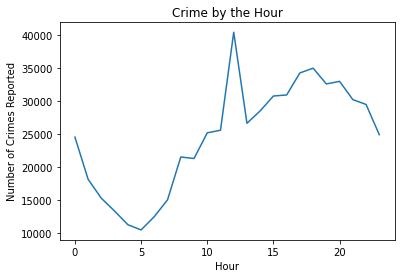

In [50]:
df['Hour OCC'].apply(int).value_counts().apply(int).sort_index().plot()
plt.xlabel('Hour')
plt.ylabel('Number of Crimes Reported')
plt.title('Crime by the Hour')
plt.show()
plt.close()

Plotting the number of crimes reported against the hour of the day confirms our hypothesis above

### Dropping Unnecessary Columns

In [51]:
# df.drop(columns = 'DR_NO', inplace = True) # DR number is all unique

# should we drop date rpt as well as we are solely intrested in the occurence of crimes?

## Linear Regression Benchmark

### Model

* Features: $x = [x_1, ...., x_n] $

* Target: $y = \sum_{i=1}^{N} a_i x_i + b$

In [52]:
class LinearModel:
  def __init__(self, num_features, with_bias=True):
    self.coeffs = torch.zeros([num_features + 1, 1]).to(torch.float64)
  
  def predict(self, x):
    x_tensor = torch.from_numpy(x).to(torch.float64)
    return self.coeffs[0, 0] + x_tensor @ self.coeffs[1:, :]
  
  def metrics(self, y_pred, y):
    y_tensor = torch.from_numpy(y).to(torch.float64)
    return torch.mean(torch.abs(y_tensor - y_pred)).detach().numpy()
  
  def metrics_rela(self, y_pred, y):
    y_tensor = torch.from_numpy(y).to(torch.float64)
    return torch.mean(torch.abs(y_tensor - y_pred) / (y_tensor + 1e-5)).detach().numpy()
  
  def mse_loss(self, y_pred, y):
    y_tensor = torch.from_numpy(y).to(torch.float64)
    return torch.mean((y_tensor - y_pred) ** 2)

  def train(self, x_train, y_train, num_epoch = 10, batch_size=64, learning_rate = 1e-3, decay=0.95):
    num_iter_per_epoch = x_train.shape[0] // batch_size + 1
    losses = []
    for e in range(num_epoch+1):
      losses_epoch = []

      idx = np.random.choice(np.arange(x_train.shape[0]), x_train.shape[0], replace=False)
      x_train = x_train[idx]
      y_train = y_train[idx]

      for it in range(num_iter_per_epoch):
        if it == num_iter_per_epoch - 1:
          x_train_batch = x_train[batch_size * it:]
          y_train_batch = y_train[batch_size * it:]
        else:
          x_train_batch = x_train[batch_size * it:batch_size * (1+it)]
          y_train_batch = y_train[batch_size * it:batch_size * (1+it)]

        self.coeffs.requires_grad_()
        y_pred = self.predict(x_train_batch)
        loss = self.mse_loss(y_pred, y_train_batch)

        with torch.no_grad():
            if self.coeffs.grad is not None:
                self.coeffs.grad.zero_()
            loss.backward()
            self.coeffs.sub_(learning_rate * self.coeffs.grad)

        losses_epoch.append(loss.detach().numpy())
      losses.append(np.mean(losses_epoch))
      if e % (num_epoch // 10) == 0:
        print(f"Epoch {e:02d}: loss - {losses[-1]:.5f}")
      
      learning_rate *= decay
    return losses

  def test(self, x_test, y_test, batch_size=64):
    num_iter_per_epoch = x_test.shape[0] // batch_size + 1

    metric = 0

    for it in range(num_iter_per_epoch):
      if it == num_iter_per_epoch - 1:
        x_test_batch = x_test[batch_size * it:]
        y_test_batch = y_test[batch_size * it:]
      else:
        x_test_batch = x_test[batch_size * it:batch_size * (1+it)]
        y_test_batch = y_test[batch_size * it:batch_size * (1+it)]

      with torch.no_grad():
        y_pred = self.predict(x_test_batch)
        metric_batch = self.metrics(y_pred, y_test_batch)
        metric += metric_batch * y_test_batch.shape[0]

    return metric / x_test.shape[0]
  
  def test_rela(self, x_test, y_test, batch_size=64):
    num_iter_per_epoch = x_test.shape[0] // batch_size + 1

    metric = 0

    for it in range(num_iter_per_epoch):
      if it == num_iter_per_epoch - 1:
        x_test_batch = x_test[batch_size * it:]
        y_test_batch = y_test[batch_size * it:]
      else:
        x_test_batch = x_test[batch_size * it:batch_size * (1+it)]
        y_test_batch = y_test[batch_size * it:batch_size * (1+it)]

      with torch.no_grad():
        y_pred = self.predict(x_test_batch)
        metric_batch = self.metrics_rela(y_pred, y_test_batch)
        metric += metric_batch * y_test_batch.shape[0]

    return metric / x_test.shape[0]

### Problem  Description

* Purpose: From the initial analysis, we find that `Month/Year`, `Latitude/Longitude`, `Victim Sex`, and `Victim Age` are some of important features that affects the number of crimes. Therefore, by using this linear regression model, we want to discuss the relation between these features and the number of crimes.
* Features:
  * Scalar Features:
    * Victim Age
    * Latitude
    * Longitude

  * Categorical Features:
    * Victim Sex (F, M, X, H)
    * Month (1 to 12)
    * Year (2020, 2021, 2022)

* Target: Given a specific month (`Month` + `Year`) , a specific region (`Lat` + `Lon`), predict **the number of crimes** happend on a specific group of people (`Vict Age` + `Vict Sex`) within that month in that region.
* Problem Type: supervised learning + regression

In [53]:
class Utils:
  def __init__(self):
    pass

  @classmethod
  def one_hot_encoding(cls, categories, data) -> np.ndarray:
    """
    Args:
      categories: [Nc, ]
      data: [N, ]
    Returns:
      result: [N, Nc]
    """
    sorted_categories = sorted(categories)

    category_map = {c: i for i, c in enumerate(sorted_categories)}

    ids = np.array(list(map(lambda c: category_map[c], data)))
   
    result = np.zeros((data.shape[0], len(categories)))

    result[np.arange(ids.size), ids] = 1

    return result


### Dataset Preparation

* Group the dataset by feature set, get the number of crimes for each group

In [54]:
df['Count'] = np.ones(df.shape[0])
df.head(5)

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Crm Cd 4,LOCATION,Cross Street,LAT,LON,Month OCC,Year OCC,Month Year OCC,Hour OCC,Count
0,10304468,2020-01-08,2020-01-08,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978,1,2020,2020-01-01,22,1.0
1,190101086,2020-01-02,2020-01-01,0330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,NaN,700 S HILL ST,NaN,34.0459,-118.2545,1,2020,2020-01-01,03,1.0
2,200110444,2020-04-14,2020-02-13,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,NaN,200 E 6TH ST,NaN,34.0448,-118.2474,2,2020,2020-02-01,12,1.0
3,191501505,2020-01-01,2020-01-01,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019,1,2020,2020-01-01,17,1.0
4,191921269,2020-01-01,2020-01-01,0415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,NaN,14400 TITUS ST,NaN,34.2198,-118.4468,1,2020,2020-01-01,04,1.0


In [55]:
scalar_features = ['LAT', 'LON', 'Vict Age']
categorical_features = ['Year OCC', 'Month OCC', 'Vict Sex']
target_feature = ['Count']
source_features = scalar_features + categorical_features
all_features = source_features + target_feature

data = df[all_features].copy()
data = data.dropna()
data['LAT'] = data['LAT'].apply(lambda x: np.round(x, 2))
data['LON'] = data['LON'].apply(lambda x: np.round(x, 2))

data = data[(data.T != 0).all()]

In [56]:
dataset = data.groupby(source_features).agg('sum').reset_index()
dataset = shuffle(dataset, random_state = 0)
dataset.head(5)
print(dataset.shape)

(372086, 7)


* Data preprocessing:
  * scalar feature: normalization
$$x_{norm} = \frac{x-\mu_x}{\sigma_x}$$
  * categorical feature: one-hot embedding

In [57]:
# Encoding dataset
dataset_enc = []
feature_end_ids = []

# scalar features:
scalar_data = dataset[scalar_features].to_numpy()
scalar_mean = scalar_data.mean(axis=0)
scalar_std = scalar_data.std(axis=0)
scalar_norm = (scalar_data - scalar_mean) / scalar_std
dataset_enc.append(scalar_norm)
feature_end_ids.extend((np.arange(len(scalar_features)) + 1).tolist())

# categorial features:
categories = { c: dataset[c].unique() for c in categorical_features }

for c in categorical_features:
  dataset_enc.append(Utils.one_hot_encoding(categories[c], dataset[c].to_numpy()))
  if len(feature_end_ids) > 0:
    feature_end_ids.append(feature_end_ids[-1] + len(categories[c]))
  else:
    feature_end_ids.append([len(categories[c])])


dataset_enc = np.concatenate(dataset_enc, axis=1)
print(dataset_enc.shape)

labels = dataset[target_feature].to_numpy().flatten()
print(labels.shape)

(372086, 22)
(372086,)


### Model Training & Testing

* Train/Test Split
  * Training size: 80%
  * Testing size: 20%

In [58]:
num_rows, num_features = dataset_enc.shape

random_seed = 0
torch.manual_seed(random_seed)
np.random.seed(random_seed)

test_size = 0.2

num_epoch = 100
learning_rate = .0001
batch_size = 256
decay = 0.95

x_train, x_test, y_train, y_test = train_test_split(
    dataset_enc, labels, test_size=test_size, random_state=random_seed)

print(x_train.shape)
print(x_test.shape)

(297668, 22)
(74418, 22)


* Training

In [59]:
# train benchmark
linear_model = LinearModel(num_features=num_features)
losses = linear_model.train(
    x_train, y_train, num_epoch=num_epoch, 
    batch_size=batch_size, learning_rate=learning_rate, decay=decay)

Epoch 00: loss - 1.39922
Epoch 10: loss - 0.44982
Epoch 20: loss - 0.44887
Epoch 30: loss - 0.44882
Epoch 40: loss - 0.44885
Epoch 50: loss - 0.44904
Epoch 60: loss - 0.44881
Epoch 70: loss - 0.44880
Epoch 80: loss - 0.44880
Epoch 90: loss - 0.44881
Epoch 100: loss - 0.44879


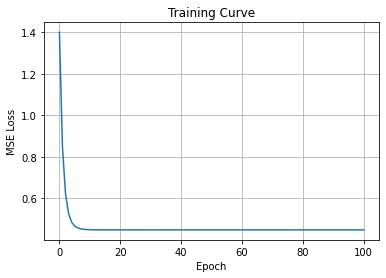

In [60]:
plt.clf()
plt.plot(np.arange(len(losses)), losses)
plt.title("Training Curve")
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")
plt.grid()
plt.show()
plt.close()

* Testing

In [61]:
metric = linear_model.test(x_test, y_test, batch_size=batch_size)
print(f"Final metrics of linear regression model = {metric:.5f}")

Final metrics of linear regression model = 0.33927


In [62]:
metric_rela = linear_model.test_rela(x_test, y_test, batch_size=batch_size)
print(f"Final relative metrics of linear regression model = {metric_rela:.5f}")

Final relative metrics of linear regression model = 0.23639


### Trained Model Comprehension

* The trained weight for each feature reveal whether the feature is positively or negatively related with the number of crimes.
  * For features with negative weights, larger feature values will causs less crimes.
  * For features with negative weights, larger feature values will causs more crimes.

* From the visualization below, we see there are two clear features with negative weights:
 * victim age
 * latitude

<Figure size 432x288 with 0 Axes>

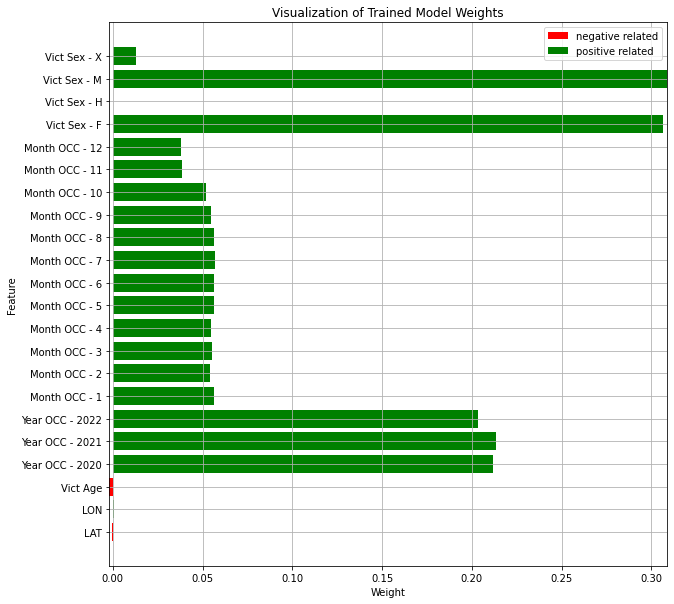

In [63]:
weights = linear_model.coeffs.detach().numpy()[1:,0]
ticks = scalar_features + [ c + ' - ' + str(sub_c) for c in categorical_features for sub_c in sorted(categories[c]) ]

neg_mask = weights < 0
pos_mask = weights >= 0

plt.clf()
plt.figure(figsize=(10, 10))
plt.barh(np.arange(len(ticks))[neg_mask], weights[neg_mask], align='center', color='red', label="negative related")
plt.barh(np.arange(len(ticks))[pos_mask], weights[pos_mask], align='center', color='green', label="positive related")
plt.yticks(ticks = np.arange(len(ticks)), labels = ticks)
plt.title('Visualization of Trained Model Weights')
plt.ylabel('Feature')
plt.xlabel('Weight')
plt.xlim([weights.min(), weights.max()])
plt.grid()
plt.legend()
plt.show()
plt.close()

* From weights of victim sex, we find male weight is larger than female's, which means men are more likely to be involved as victim in crimes. This can be proved by querying the dataset as below:

In [30]:
dataset.groupby('Vict Sex').agg('sum')['Count']

Vict Sex
F    214356.0
H        64.0
M    226530.0
X      4913.0
Name: Count, dtype: float64

* From weights of month, we find November and December are most unlikely to have crimes. This can also be proved by querying the dataset as below:

In [31]:
dataset.groupby('Month OCC').agg('sum')['Count']

Month OCC
1     40119.0
2     38238.0
3     39313.0
4     38461.0
5     40609.0
6     40552.0
7     41767.0
8     41101.0
9     39188.0
10    36293.0
11    25349.0
12    24873.0
Name: Count, dtype: float64

* From weights of latitude and longitude, we find that larger latitude (more East on the map), and less longitude (more South on the map), there will be fewer number of crimes, which matches perfectly with the crime heatmap [[source page](https://products.xtown.la/map)].



<img src="https://lh3.googleusercontent.com/drive-viewer/AJc5JmRPygO5kVSH435ykA4fHIq3R2NMUfasGAumtSudRpTKpucnc9cGloLb4P1PGwUeqlEsVsFDAbuMUIgK2-TxaBd9ZY2Qcg=w2346-h1712" alt="drawing" width="400"/>

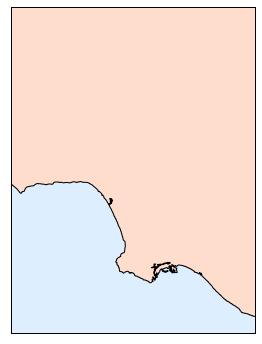

In [32]:
# draw regions in the dataset
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='gnom', lat_0=dataset['LAT'].mean(), lon_0=dataset['LON'].mean(),
            width=90000, height=120000, resolution='f')
m.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF')
m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines()

### Conclusion
* Basic linear regression model can reveal positive/negative relations between features and the number of crimes correctly.
* Basic linear regression is relatively hard to converge and have high error in metrics for testing data.